# Load Processed Data

## Helper Functions

In [79]:
from typing import List, Set
from sklearn.preprocessing import LabelEncoder, OneHotEncoder


def getUniqueSetOfChars(words_lst: List[str]) -> List[str]:
    '''
    Find a list of unique chars in words_lst. This is needed for the one hot encoding to turn words into numerical vectors
    '''
    unique_chars = set()
    for word in words_lst:
        unique_chars.update(set(word))
    return list(unique_chars)

# print(getUniqueSetOfChars(words_lst))



def oneHotEncodeStrings(unique_chars: List[str], strings: List[List[str]]) -> List[List[int]]:
    char_indices = {char: i for i, char in enumerate(unique_chars)}
    encoded_vectors = []
    
    for string_list in strings:
        encoded_string = [
            [1 if char in string else 0 for char in unique_chars]
            for string in string_list
        ]
        encoded_vectors.append([val for sublist in encoded_string for val in sublist])
    
    return encoded_vectors



test = ['apple', 'banana', 'orange']
print(oneHotEncodeStrings(getUniqueSetOfChars(test) ,test))
# print(len(oneHotEncodingCharacters(test)[0]))
print(len(set("".join(test))))

[[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]]
9


In [3]:
def deskew_process(image):
	# deskew image
	image = ioski.imread(sample_img)
	grayscale = rgb2gray(image)
	angle = determine_skew(grayscale)
	rotated = rotate(image, angle, resize=True) * 255
	return rotated

In [3]:
def find_key_index(dictionary, key):
    keys_list = list(dictionary.keys())
    try:
        index = keys_list.index(key)
        return index
    except ValueError:
        return None

## Load Dataset

In [6]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import keras
import matplotlib.pyplot as plt
import pickle # load variables.pkl
import cv2 # image preprocessing
import os

IMAGE_DIR = os.getcwd() + "/Datasets/words/"
IMAGE_WIDTH = 128
IMAGE_HEIGHT = 128

# Step 1: Data collection - Prepare your labeled dataset
with open("./variables.pkl", "rb") as file:
    (
        filepaths_lst,
        words_lst,
        filepaths_dic,
        words_dic,
    ) = pickle.load(file)

with open("./filtered_data/processed_images.pkl", "rb") as file:
    (
        processed_images
    ) = pickle.load(file)


print("Load Complete")

Load Complete


## Preprocess Dataset

In [8]:
def pre_process_image(image, TARGET_HEIGHT=100, TARGET_WIDTH=100):
    """This function will pre-process a image with: cv2 & deskew
    so it can be process by tesseract"""
    '''
    img = cv2.imread(image)
    img = cv2.resize(img, None, fx=.3, fy=.3) #resize using percentage
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #change color format from BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #format image to gray scale
    img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 5, 11) #to remove background
    '''
    original_height, original_width = image.shape[:2]
    # print(original_height, original_width)
    aspect_ratio = original_width / original_height

    if aspect_ratio >= 1.0:  # Landscape image
        new_width = TARGET_WIDTH
        new_height = int(new_width / aspect_ratio)
    else:  # Portrait image
        new_height = TARGET_HEIGHT
        new_width = int(new_height * aspect_ratio)

    # Resize the image to the target size.
    resized_image = cv2.resize(image, (new_width, new_height))

    # Pad the resized image to make it the target size.
    padded_image = np.ones((TARGET_HEIGHT, TARGET_WIDTH), dtype=np.uint8) * 255
    x_offset = (TARGET_WIDTH - new_width) // 2
    y_offset = (TARGET_HEIGHT - new_height) // 2
    padded_image[y_offset:y_offset + new_height, x_offset:x_offset + new_width] = resized_image

    return padded_image

In [9]:
def pre_process_image_skew(image, TARGET_HEIGHT=100, TARGET_WIDTH=100):
    '''
    old preprocessing function that skews the original image
    '''
    #print(image_path)
    height, width = image.shape
    #print(f"Image dimensions: {width} x {height}")
    image = cv2.resize(image, (TARGET_WIDTH, TARGET_HEIGHT))  # Resize the image to a fixed size
    image_tensor = tf.convert_to_tensor(image, dtype=tf.float32)
    image_tensor = image_tensor / 127.5 - 1.0  # Normalize pixel values between 0 and 1

    # Add the preprocessed image and its corresponding label to the lists
    processed_images.append(image)
    return image

In [10]:

processed_images = []
bad = []
TARGET_HEIGHT, TARGET_WIDTH = 100, 100

# TEST_SIZE = 10

# Step 3: process the images into normlized 100*100 grayscale images
for i, image_path in enumerate(filepaths_dic.keys()):
    # if i > TEST_SIZE: 
    #     break
    
    # Load and preprocess the image
    #if image_path in bad_data: # bad data
        #continue
    image = cv2.imread(IMAGE_DIR+image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        bad.append(image_path)
        continue
    height, width = image.shape
    """
    change preprocess methods here
    """
    padded_image = pre_process_image(image, TARGET_HEIGHT, TARGET_WIDTH)
    # Add the preprocessed image and its corresponding label to the lists
    processed_images.append(padded_image)

[ WARN:0@693.455] global loadsave.cpp:248 findDecoder imread_('/Users/aaron68lee/Documents/Coding-Projects/ForgeNet/Datasets/words/a01/a01-117/a01-117-05-02.png'): can't open/read file: check file path/integrity
[ WARN:0@911.755] global loadsave.cpp:248 findDecoder imread_('/Users/aaron68lee/Documents/Coding-Projects/ForgeNet/Datasets/words/r06/r06-022/r06-022-03-05.png'): can't open/read file: check file path/integrity


In [ ]:

print("Bad", bad)

NameError: name 'bad' is not defined

Exchange


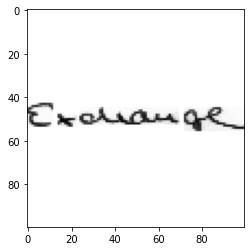

In [2]:
# test processed_image by plot out one processed image
import matplotlib.pyplot as plt

print(words_lst[50])
plt.imshow(processed_images[50], cmap="gray")

In [48]:

# Step 5: Data preparation
# Prepare your training dataset with input text and corresponding preprocessed images

from sklearn.model_selection import train_test_split

# Variable "processed_images_to_text" holds pairs of images (tensor arrays) to their text label
# Ex. [tensor array for "Exchange", 'Exchange']
processed_images_to_text = []
for i in range(len(processed_images)):
    processed_images_to_text.append([processed_images[i], words_lst[i]])

# Split the dataset into train and test sets (80% train, 20% test)
train, test = train_test_split(processed_images_to_text, test_size=0.2, random_state=42, shuffle=True)

# Split the test set further into test and validation sets (50% test, 50% validation)
test, val = train_test_split(test, test_size=0.5, random_state=42, shuffle=True)

# Print the sizes of each split
print("Dataset Size:", len(processed_images))
print("Train set size:", len(train))
print("Test set size:", len(test))
print("Validation set size:", len(val))

image_labels = [train[i][1] for i in range(len(train))] #List of all the text labels after shuffling 
images = [train[i][0] for i in range(len(train))] #List of all the image tensors after shuffling 


Dataset Size: 115239
Train set size: 92191
Test set size: 11524
Validation set size: 11524


# OCR Model

In [11]:
# Use a pipeline as a high-level helper
from transformers import pipeline
pipe = pipeline("image-to-text", model="microsoft/trocr-base-handwritten")


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
/opt/miniconda3/lib/python3.9/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


## OCR Metrics

In [35]:
import editdistance
import Levenshtein

def cer(reference, hypothesis):
    # get character error rate
    ref_length = len(reference)
    hyp_length = len(hypothesis)
    distance = [[0] * (hyp_length + 1) for _ in range(ref_length + 1)]

    for i in range(ref_length + 1):
        distance[i][0] = i
    for j in range(hyp_length + 1):
        distance[0][j] = j

    for i in range(1, ref_length + 1):
        for j in range(1, hyp_length + 1):
            cost = 0 if reference[i - 1] == hypothesis[j - 1] else 1
            distance[i][j] = min(
                distance[i - 1][j] + 1,
                distance[i][j - 1] + 1,
                distance[i - 1][j - 1] + cost
            )

    cer = distance[ref_length][hyp_length] / max(ref_length, hyp_length)
    return cer

def edit_distance(ground_truth, hypothesis):
    edit_dist = editdistance.eval(ground_truth, hypothesis)
    return edit_dist

def levenshtein_distance(ground_truth, hypothesis):
    levenshtein_dist = Levenshtein.distance(ground_truth, hypothesis)
    return levenshtein_dist

def get_accuracy_metrics(ground_truth, hypothesis):
    return cer(ground_truth, hypothesis), wer(ground_truth, hypothesis), edit_distance(ground_truth, hypothesis)

def OCR(image_path, model=pipe): # can define custom OCR pretrained model to use #, model_path="./SimpleHTR-master/model"):

    '''
    # Load the HTR-DeepWriting model
    char_list_path = os.path.join(model_path, 'charList.txt')
    model = Model(open(char_list_path).read(), decoderType=DecoderType.BestPath, mustRestore=True)

    # Perform word segmentation
    word_images = word_segmentation(image)

    # Recognize handwriting for each word image
    recognized_text = []
    for word_img in word_images:
        word_text = model.inferWord(word_img)
        recognized_text.append(word_text)

    # Join recognized words into a single string
    final_text = ' '.join(recognized_text)

    print("Recognized Text:")
    print(final_text)
    '''

    # Perform OCR on the image
    result = model(image_path)
    text = result[0]["generated_text"]
    
    return text

## Example

In [7]:

import os
sample = 'e04/e04-127/e04-127-04-05.png'
image_path = os.path.join('./Datasets/words', sample)

ground_truth = filepaths_dic[sample] # words_lst[i]
print("Ground Truth:", ground_truth)
print(image_path)



Ground Truth: coloured
./Datasets/words/e04/e04-127/e04-127-04-05.png


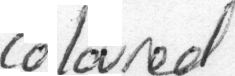

52


In [16]:
from PIL import Image

img = Image.open(image_path)
display(img)

print(len(processed_images))

In [13]:
hypothesis = OCR(image_path)
print(hypothesis)

/opt/miniconda3/lib/python3.9/site-packages/transformers/generation/utils.py:1313: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


co launch


In [14]:
index = find_key_index(filepaths_dic, sample)
print(index)

42803


In [32]:
print(words_lst[0:40])

['A', 'MOVE', 'to', 'stop', 'Mr.', 'Gaitskell', 'from', 'nominating', 'any', 'more', 'Labour', 'life', 'Peers', 'is', 'to', 'be', 'made', 'at', 'a', 'meeting', 'of', 'Labour', 'Ps', 'tomorrow', '.', 'Mr.', 'Michael', 'Foot', 'has', 'put', 'down', 'a', 'resolution', 'on', 'the', 'subject', 'and', 'he', 'is', 'to']


Ground Truth: nominating


/opt/miniconda3/lib/python3.9/site-packages/transformers/generation/utils.py:1313: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


PyTesseract Hypothesis: twig



NameError: name 'reference' is not defined

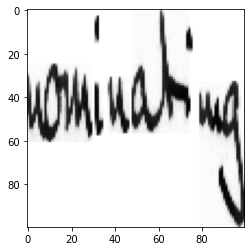

In [36]:
# EXAMPLE using Pytesseract (less accurate)

import pytesseract
from fuzzywuzzy import fuzz
from jiwer import wer

i = 7

ground_truth = words_lst[i] #'materials'
print("Ground Truth:", ground_truth)
plt.imshow(processed_images[i], cmap="gray")

py_hypothesis = pytesseract.image_to_string(processed_images[i])

sample = list(filepaths_dic.keys())[i]
image_path = os.path.join('./Datasets/words', sample)
transformer_hypothesis = OCR(image_path)

print("PyTesseract Hypothesis:", py_hypothesis)
print("CER: ", cer(ground_truth, py_hypothesis)) # char error rate
print("WER: ", wer(ground_truth, py_hypothesis)) # word error rate
print("Edit distance: ", edit_distance(ground_truth, py_hypothesis)) # edit distance
print("Levenshtein distance: ", levenshtein_distance(ground_truth, py_hypothesis)) # levenshtein distance
print("________________")

print("TrOCR Transformer Hypothesis:", transformer_hypothesis)
print("CER: ", cer(ground_truth, transformer_hypothesis)) # char error rate
print("WER: ", wer(ground_truth, transformer_hypothesis)) # word error rate
print("Edit distance: ", edit_distance(ground_truth, transformer_hypothesis)) # edit distance
print("Levenshtein distance: ", levenshtein_distance(ground_truth, transformer_hypothesis)) # levenshtein distance

print("Ground Truth:", ground_truth)


## Evaluating OCR Model on Dataset

In [20]:

# ================== Iterate through all images in subfolders recursively =======================
from tqdm import tqdm

def OCR_all(folder_path, model=pipe, MAX_ITER=float('inf'), progress=False, save_output=False):
  '''
  Function performs OCR processing on this file structure:
  root
    subfolders
      sub-subfolders
        images

  Save output flag toggles creation of additional subfolders for preprocessed images (NOT APPLICABLE)
  '''
  
  iter = 0

  def process_subfolder(subfolder_path):
    nonlocal iter
    # Get a list of files in the folder
    file_list = os.listdir(subfolder_path)

    # Initialize tqdm with the total number of files
    if progress:
      progress_bar = tqdm(file_list, desc='Processing Images', unit='image')
      iterator = progress_bar
    else:
      iterator = file_list
      
    for file_name in iterator:
      if iter >= MAX_ITER:
        break

      # Check if the file has an image extension
      if file_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
          img = os.path.splitext(file_name)[0]  # Get the image name without extension
          image_path = os.path.join(subfolder_path, file_name)
          
          if save_output:
            # processed output folder
            output_folder = os.path.join(subfolder_path, img)

            if not os.path.exists(output_folder): # folder for patient i with extracted data
                os.makedirs(output_folder)

          ########################### # do processing # ###########################

          predict = OCR(image_path, model)
          #print("Iteration: ", iter, " | File:", file_name)
          print("Path:", image_path)

          iter += 1

  def traverse_folder(root_folder):
    for root, dirs, files in os.walk(root_folder):
        for dir in dirs:
            subfolder_path = os.path.join(root, dir)
            process_subfolder(subfolder_path)

  traverse_folder(folder_path)

  print("Processing completed.")

Path: ./Datasets/words/e04/e04-127/e04-127-04-05.png
Path: ./Datasets/words/e04/e04-127/e04-127-06-00.png
Path: ./Datasets/words/e04/e04-127/e04-127-01-09.png
Path: ./Datasets/words/e04/e04-127/e04-127-06-01.png
Path: ./Datasets/words/e04/e04-127/e04-127-01-08.png
Processing completed.


In [ ]:
word_path = './Datasets/words/'
sentence_path = './Datasets/sentences'

OCR_all(word_path, 5)

In [56]:
import pandas as pd

# iterate through word dataset

TEST_SIZE = 10

word_scores = []
word_score_model = []

for i in range(len(processed_images)): 
    if i > TEST_SIZE:
        break
    ground_truth = words_lst[i]
    hypothesis = pytesseract.image_to_string(processed_images[i])
    cer_score, wer_score, edit_distance_score = get_accuracy_metrics(ground_truth, hypothesis)
    word_scores.append([cer_score, wer_score, edit_distance_score])

#### TODO #####

sent_scores = [] 
sent_score_model = []

for i in range(len(processed_images)): 
    if i > TEST_SIZE:
        break
    ground_truth = words_lst[i]
    hypothesis = pytesseract.image_to_string(processed_images[i])
    cer_score, wer_score, edit_distance_score = get_accuracy_metrics(ground_truth, hypothesis)
    sent_scores.append([cer_score, wer_score, edit_distance_score])


average cer, wer, edit_distance scores: [0.21856476856476856, 1.2727272727272727, 3.727272727272727]


,CER,WER,Edit Distance
0,0.000000,1.0,1
1,0.000000,0.0,1
2,0.000000,0.0,1
3,0.500000,1.0,2
4,0.000000,1.0,3
5,0.583333,4.0,9
6,0.200000,1.0,2
7,0.692308,3.0,11
8,0.000000,1.0,3
9,0.000000,1.0,4


In [ ]:

def get_col_average(scores):
    transposed_data = zip(*scores)
    column_averages = [sum(column) / len(column) for column in transposed_data]
    return column_averages


print("average cer, wer, edit_distance scores:", get_col_average(scores))


In [57]:
score_df = pd.DataFrame(scores, columns=['CER', 'WER', 'Edit Distance'])
display(score_df)

,CER,WER,Edit Distance
0,0.000000,1.0,1
1,0.000000,0.0,1
2,0.000000,0.0,1
3,0.500000,1.0,2
4,0.000000,1.0,3
5,0.583333,4.0,9
6,0.200000,1.0,2
7,0.692308,3.0,11
8,0.000000,1.0,3
9,0.000000,1.0,4


## Fine-tuning OCR Model

In [ ]:
import torch
from torch.utils.data import Dataset

class CustomImageTextDataset(Dataset):
    def __init__(self, image_paths, labels):
        self.image_paths = image_paths
        self.labels = labels

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]

        # Load and preprocess the image (you'll need to implement this)
        image = preprocess_image(image_path)

        return {
            "image": image, # image path
            "label": label
        }

# Example paths and labels
image_paths = ["path_to_image_1.jpg", "path_to_image_2.jpg", ...]
labels = ["label_1", "label_2", ...]

In [ ]:
import torch
from transformers import TrainingArguments, Trainer, pipeline, TrocrForImageToText

# Load your labeled dataset (images and corresponding text labels)
# You'll need to write code to read and preprocess this data

# Load the pre-trained model
model = TrocrForImageToText.from_pretrained("microsoft/trocr-base-handwritten")

# Configure the training arguments
training_args = TrainingArguments(
    output_dir="./saved",   # Directory to save the fine-tuned model
    num_train_epochs=5,               # Number of training epochs
    per_device_train_batch_size=4,    # Batch size
    save_steps=1000,                  # Save model checkpoints every X steps
    evaluation_strategy="steps",      # Evaluate every X steps
    eval_steps=500,                   # Evaluate every X steps
    logging_steps=100,                # Log metrics every X steps
    learning_rate=1e-4,               # Learning rate
    do_train=True,                    # Start training
    do_eval=True,                     # Evaluate during training
    # Add more training arguments as needed
)

# Create a Trainer instance
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=your_train_dataset,   # Your training dataset
    eval_dataset=your_val_dataset,      # Your validation dataset
)

# Fine-tune the model
trainer.train()

# Evaluate the fine-tuned model
results = trainer.evaluate()

print(results)


# Loss Functions

In [ ]:
import keras

def reconstruction_loss(inputs, outputs):
    reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
    reconstruction_loss *= (IMAGE_WIDTH * IMAGE_HEIGHT)  # Image size
    return reconstruction_loss

def kl_divergence_loss(z_mean, z_log_var):
    # Kullback-Leiber Divergence Loss
    kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
    return kl_loss

def vae_loss(inputs, outputs, z_mean, z_log_var):
    reconstruction = reconstruction_loss(inputs, outputs)
    kl_divergence = kl_divergence_loss(z_mean, z_log_var)
    return reconstruction + kl_divergence


# GAN-type Model Architecture

In [53]:
print(type(image_labels))
print(type([images]))

<class 'list'>
<class 'list'>


## GAN Architecture

In [ ]:
# Generative Adversarial Network

# Step 4: Model selection
latent_dim = 100
text_dim = 128
image_dim = (IMAGE_WIDTH, IMAGE_HEIGHT, 1) # using grayscale

# Generator model - makes an image from text and noise
generator_input = layers.Input(shape=(latent_dim + text_dim,))
# hidden layers
x = layers.Dense(256)(generator_input)
x = layers.LeakyReLU()(x)
x = layers.Dense(512)(x)
x = layers.LeakyReLU()(x)
x = layers.Dense(1024)(x)
x = layers.LeakyReLU()(x)
generator_output = layers.Dense(image_dim, activation='tanh')(x)
generator = tf.keras.Model(generator_input, generator_output)

# Discriminator model - classification model to predict real vs. fake 
discriminator_input = layers.Input(shape=(image_dim,))
x = layers.Dense(512)(discriminator_input)
x = layers.LeakyReLU()(x)
x = layers.Dense(256)(x)
x = layers.LeakyReLU()(x)
x = layers.Dense(128)(x)
x = layers.LeakyReLU()(x)
discriminator_output = layers.Dense(1, activation='sigmoid')(x)
discriminator = tf.keras.Model(discriminator_input, discriminator_output)

# Combined model
gan_input = layers.Input(shape=(latent_dim + text_dim,))
generated_image = generator(gan_input)
discriminator.trainable = False
gan_output = discriminator(generated_image)
gan = tf.keras.Model(gan_input, gan_output)



## Alternative Architecture

In [ ]:
# Generator model
def build_generator():
    input_noise = layers.Input(shape=(latent_dim,))
    input_text = layers.Input(shape=(text_dim,))

    # Concatenate the noise and text input
    combined_input = layers.Concatenate()([input_noise, input_text])

    x = layers.Dense(256)(combined_input)
    x = layers.LeakyReLU()(x)
    x = layers.Reshape((8, 8, 4))(x)

    x = layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU()(x)

    output_image = layers.Conv2D(1, (3, 3), activation='tanh', padding='same')(x)

    generator = models.Model(inputs=[input_noise, input_text], outputs=output_image, name='Generator')
    return generator

# Discriminator model
def build_discriminator():
    input_image = layers.Input(shape=image_dim)
    input_text = layers.Input(shape=(text_dim,))

    x = layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same')(input_image)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU()(x)

    x = layers.Flatten()(x)

    # Concatenate the image features and text input
    combined_input = layers.Concatenate()([x, input_text])

    x = layers.Dense(256)(combined_input)
    x = layers.LeakyReLU()(x)

    output_pred = layers.Dense(1, activation='sigmoid')(x)

    discriminator = models.Model(inputs=[input_image, input_text], outputs=output_pred, name='Discriminator')
    return discriminator

## Train GAN Model

In [61]:
# Step 6: Model training

from tqdm import tqdm

batch_size = 32
epochs = 100
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

for epoch in tqdm(range(epochs), desc='Epochs', unit='epoch'):
    for batch in tqdm(range(len(train) // batch_size), desc='Batches', unit='batch', leave=False): #range(len(train) // batch_size):
        # Generate random noise and text input
        noise = np.random.normal(size=(batch_size, latent_dim))

        text_input = image_labels[batch:(batch + batch_size)] # process string -> vector
        # consider OneHot Encoding characters
        
        # Generate images from noise and text input
        # generator input shape should be (latent_dim + text_dim,)
        generated_images = generator.predict([noise, text_input])

        # Combine real and generated images for the discriminator
        real_images = images[batch:(batch + batch_size)]  # Custom function to get real images
        combined_images = np.concatenate([real_images, generated_images])

        # Labels for real and generated images
        labels = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])
        labels += 0.05 * np.random.random(labels.shape)

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = discriminator(combined_images)
            discriminator_loss = loss(labels, predictions)
        grads = tape.gradient(discriminator_loss, discriminator.trainable_weights)
        optimizer.apply_gradients(zip(grads, discriminator.trainable_weights))

        # Train the generator (via the gan model)
        noise = np.random.normal(size=(batch_size, latent_dim))
        text_input = image_labels[batch:(batch + batch_size)]  # Custom function to get text input
        labels = np.ones((batch_size, 1))
        with tf.GradientTape() as tape:
            generated_images = generator([noise, text_input])
            predictions = discriminator(generated_images)
            generator_loss = loss(labels, predictions)
        grads = tape.gradient(generator_loss, generator.trainable_weights)
        optimizer.apply_gradients(zip(grads, generator.trainable_weights))


Epochs:   0%|          | 0/100 [00:00<?, ?epoch/s]


ValueError: Failed to find data adapter that can handle input: (<class 'list'> containing values of types {'(<class \'list\'> containing values of types {"<class \'str\'>"})', "<class 'numpy.ndarray'>"}), <class 'NoneType'>

## Alt Training Loop

In [ ]:
# Step 6: Model training
def train_gan(gan, generator, discriminator, train_data, epochs, batch_size):
    for epoch in range(epochs):
        for batch in range(len(train_data) // batch_size):
            noise = np.random.normal(size=(batch_size, latent_dim))
            text_input = train_data[batch * batch_size : (batch + 1) * batch_size, 1]

            generated_images = generator.predict([noise, text_input])

            real_images = train_data[batch * batch_size : (batch + 1) * batch_size, 0]
            combined_images = np.concatenate([real_images, generated_images])

            labels = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])
            labels += 0.05 * np.random.random(labels.shape)

            d_loss = discriminator.train_on_batch(combined_images, labels)

            noise = np.random.normal(size=(batch_size, latent_dim))
            text_input = train_data[batch * batch_size : (batch + 1) * batch_size, 1]
            labels = np.ones((batch_size, 1))

            g_loss = gan.train_on_batch([noise, text_input], labels)

            print(f"Epoch {epoch}/{epochs}, Batch {batch}/{len(train_data) // batch_size}, D Loss: {d_loss}, G Loss: {g_loss}")

## GAN Evaluation

In [ ]:
# Step 7: Generate sample images and evaluate the GAN model

# Create a function to generate and save sample images
def generate_images(model, epoch, noise_dim, num_examples_to_generate, text_input, dir='./generated'):
    """
    Generate a 4x4 grid of images from a GAN model.
    Args:
        model: The GAN model that will be used to generate the images.
        epoch: The epoch at which the images will be generated.
        noise_dim: The dimensionality of the noise vector that will be used to generate the images.
        num_examples_to_generate: The number of images that will be generated.
        text_input: The text input that will be used to condition the GAN model.
    Returns:
        None.
    """
    # Process the text input with the dimension of noise
    predictions = model([noise_dim, text_input])
    # Create a new figure with a size of 3 x 3 inches
    fig = plt.figure(figsize=(3, 3))
    # Loop over the generated images
    for i in range(predictions.shape[0]):
        # Create a subplot in the figure
        plt.subplot(4, 4, i + 1)
        # Plot the image in the subplot
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        # Set the axis of the subplot to `off`
        plt.axis('off')
        # Save the figure as a PNG file with the name `image_at_epoch_{epoch}.png`
        #path = os.path(dir)
        plt.savefig(f'./{dir}/image_at_epoch_{epoch}.png')
        plt.close()

# Define the noise dimension for generating sample images
noise_dim = 100

# Create random noise and text input for generating sample images
num_examples_to_generate = 16
noise = np.random.normal(size=(num_examples_to_generate, noise_dim))
text_input = get_random_text_input(0, num_examples_to_generate)  # Custom function to get text input

# Generate and save sample images using the generator model
generate_and_save_images(generator, 0, noise_dim, num_examples_to_generate, text_input)

# Evaluate the GAN model
# You can define evaluation metrics or procedures here to assess the quality of generated images and discriminator performance.
# For example, you can use an external evaluation metric like FID (Fréchet Inception Distance) or manually inspect the generated images.

# Save the trained generator and discriminator models
generator.save('gan_generator.h5')
discriminator.save('gan_discriminator.h5')


## GAN Inference

In [ ]:

# Step 9: Generation - Generate new images based on input text
input_text = "Hello, World!"
noise = np.random.normal(size=(1, latent_dim))
text_input = preprocess_text(input_text)  # Custom function to preprocess input text
generated_image = generator.predict([noise, text_input])

# Display or save the generated image

# VAE-type Model Architecture

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras
import sys

path = "/Users/aaron68lee/Documents/Coding-Projects/ForgeNet/GAN_VAE_Model"
sys.path.append(path)

In [ ]:
latent_dim = 128  # Dimensionality of the latent space

# Encoder
encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var], name="encoder")

# Decoder
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

# Variational Autoencoder
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        z_mean, z_log_var = self.encoder(inputs)
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        z = z_mean + tf.exp(0.5 * z_log_var) * epsilon
        reconstructed = self.decoder(z)
        return reconstructed

# instantiate VAE model and loss metrics
vae = VAE(encoder, decoder)
optimizer = keras.optimizers.Adam()
vae.compile(optimizer, loss=vae_loss)

## Train VAE Model

In [ ]:
vae.fit(dataset, epochs=10, batch_size=64)

random_latent_vectors = tf.random.normal(shape=(num_samples, latent_dim))
generated_images = decoder(random_latent_vectors)

## VAE Inference

In [ ]:
path_to_saved_model = '/content/scrabble-gan/res/out/big_ac_gan/model/generator_' + str(epochs)

# number of samples to generate
n_samples = 10
# your sample string
sample_string = 'machinelearning'

# load trained model
imported_model = tf.saved_model.load(path_to_saved_model)

# inference loop
for idx in range(1):
  fake_labels = []
  words = [sample_string] * 10
  noise = tf.random.normal([n_samples, latent_dim])
  
  # encode words
  for word in words:
    fake_labels.append([char_vec.index(char) for char in word])
  fake_labels = np.array(fake_labels, np.int32)

  # run inference process
  predictions = imported_model([noise, fake_labels], training=False)
  # transform values into range [0, 1]
  predictions = (predictions + 1) / 2.0

  # plot results
  for i in range(predictions.shape[0]):
    plt.subplot(10, 1, i + 1)
    plt.imshow(predictions[i, :, :, 0], cmap='gray')
    # plt.text(0, -1, "".join([char_vec[label] for label in fake_labels[i]]))
    plt.axis('off')
    plt.show()

# Generation with GAN_VAE_Model Framework

In [ ]:
# run shell
# python ./GAN_VAE_Model/generate.py -d ./generated


# Post-processing

# Save and Load Project States

In [27]:
# Save Stuff

# Put processed images in new folder
import pickle
with open("./filtered_data/processed_images.pkl", "wb") as file:
    pickle.dump(processed_images, file)
print("Save Complete")

Save Complete


In [28]:
# Load Stuff
with open("./filtered_data/processed_images.pkl", "rb") as file:
    (
        processed_images
    ) = pickle.load(file)
print("Load Complete")

Load Complete


115239